# Transfer Learning

## Importar Librerías y montar el drive

In [ ]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Cargar y adecuar los datos

Descargar y descomprimir los archivos

In [ ]:
!wget --no-check-certificate \
   https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0\
   -O cats_and_dogs_small.zip

local_zip = 'cats_and_dogs_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

--2022-11-16 17:36:11--  https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip [following]
--2022-11-16 17:36:11--  https://www.dropbox.com/s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd5c6c5cb680f9d09ee626aa321.dl.dropboxusercontent.com/cd/0/inline/Bw6AQdhwV7kK4EfHIv-GGy9bAHi1RQEjMtJYZn1Q2d-kIVaHbH0Ya6Ig7tbThUcqlnuoV8ND5ddRDErkYAoiJ6T91JtMwvfUzYVANaky1Y05gJLmHVJ2oP9LR7ANPLgYIszRzaLUzPOqP9CZ8pJ_zCy9M71wyEkh1EHF30OshMQfEg/file# [following]
--2022-11-16 17:36:12--  https://ucd5c6c5cb680f9d09ee626aa321.dl.dropboxusercontent.com/cd/0/inline/Bw6AQdhwV7kK4EfHIv-GGy9bAHi1RQEjMtJYZn1

Configurar y dividir dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

path = '/content/cats_and_dogs_small'

# Nuevas dimensiones para las imágenes
height = 150
width = 150

# Crear el dataset a partir del directorio
dataset = image_dataset_from_directory(directory=path, label_mode='int', class_names=['dogs','cats'], batch_size=None, image_size=(height,width))

Found 4000 files belonging to 2 classes.


Colocar todos los datos en arreglos

In [ ]:
# En estas listas se guardaran los datos
imagenes = []
etiquetas = []

for (imagen, etiqueta) in dataset:
  imagenes.append(imagen)
  etiquetas.append(etiqueta)

# Convertir listas en arreglos
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

In [ ]:
# Contar cuántos elementos hay para cada clase
clase1 = 0
clase2 = 0

for n in range(len(etiquetas)):
  if etiquetas[n]==0:
    clase1 +=1
  elif etiquetas[n]==1:
    clase2 += 1

print('La clase 1 posee ', clase1, ' elementos')
print('La clase 2 posee ', clase2, ' elementos')

if clase1==clase2:
  print('Las clases están balanceadas')

La clase 1 posee  2000  elementos
La clase 2 posee  2000  elementos
Las clases están balanceadas


Crear conjunto de entrenamiento, validación y test

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos
xtrain, xval, ytrain, yval = train_test_split(imagenes, etiquetas, train_size=0.6, random_state=13)
xval, xtest, yval, ytest = train_test_split(xval, yval, train_size = 0.5, random_state=13)

# Mostrar el tamaño de cada conjunto
print('Tamaño de los Datos')
print('Entrenamiento: \n', xtrain.shape, ytrain.shape)
print('Validación: \n', xval.shape, yval.shape)
print('Test: \n', xtest.shape, ytest.shape)

Tamaño de los Datos
Entrenamiento: 
 (2400, 150, 150, 3) (2400,)
Validación: 
 (800, 150, 150, 3) (800,)
Test: 
 (800, 150, 150, 3) (800,)


Normalizar

In [ ]:
# Función para normalizar imágenes
def preproceso(imagen):
  img = imagen/255.0
  return img

# Resize y normalización de las imágenes
xtrain = np.array(list(map(preproceso, xtrain)))
xval = np.array(list(map(preproceso, xval)))
xtest = np.array(list(map(preproceso, xtest)))

Visualizar algunos ejemplos del dataset

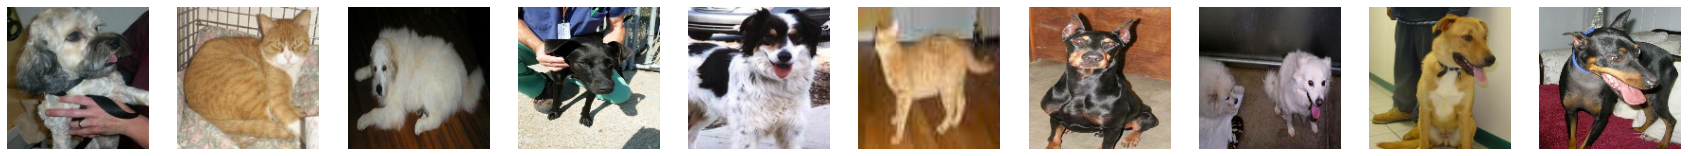

In [ ]:
plt.figure(figsize=(30,20))

for index, (imagen, etiqueta) in enumerate(zip(xtrain[0:10], ytrain[0:10])):
  plt.subplot(1, 10, index+1)
  plt.imshow(imagen)
  plt.axis('off')

Codificación One Hot

In [ ]:
from tensorflow.keras.utils import to_categorical

ytrain = to_categorical(ytrain, 2)
yval = to_categorical(yval, 2)
ytest = to_categorical(ytest, 2)

print(ytrain[0])

## Clasificación con diferentes arquitecturas de redes

Las redes que se usarán requieren valores entre -1 y 1, para esto usaremos el módulo de preprocesamiento de la red Xception, aunque igual se podría usar el de las otras, pues hacen lo mismo

In [ ]:
# xtrain = tf.keras.applications.xception.preprocess_input(xtrain)
# xval = tf.keras.applications.xception.preprocess_input(xval)
# xtest = tf.keras.applications.xception.preprocess_input(xtest)

[1. 0.]


### Redes sin pesos transferidos

#### Red Neuronal Personal usada en el Examen 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

model1 = Sequential()
model1.add(Conv2D(10, (5,5), strides=1, activation='relu', input_shape=(150,150,3), padding='valid'))
model1.add(AveragePooling2D(pool_size=(2,2)))
model1.add(Conv2D(50, (5,5), strides=1, activation='relu', padding='valid'))
model1.add(AveragePooling2D(pool_size=(2,2)))
model1.add(Conv2D(200, (5,5), strides=1, activation='relu', padding='valid'))
model1.add(tf.keras.layers.Flatten())
model1.add(Dense(units=90, activation='relu'))
model1.add(Dense(units=30, activation='relu'))
model1.add(Dense(units=2, activation='softmax'))

model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=15, batch_size=32, verbose=1)

Epoch 1/15
75/75 [==============================] - 10s 15ms/step - loss: 0.7860 - accuracy: 0.5025 - val_loss: 0.6902 - val_accuracy: 0.5263
Epoch 2/15
75/75 [==============================] - 1s 11ms/step - loss: 0.6914 - accuracy: 0.5133 - val_loss: 0.6923 - val_accuracy: 0.5138
Epoch 3/15
75/75 [==============================] - 1s 11ms/step - loss: 0.6941 - accuracy: 0.5242 - val_loss: 0.6873 - val_accuracy: 0.5337
Epoch 4/15
75/75 [==============================] - 1s 11ms/step - loss: 0.6830 - accuracy: 0.5412 - val_loss: 0.6816 - val_accuracy: 0.5512
Epoch 5/15
75/75 [==============================] - 1s 11ms/step - loss: 0.6752 - accuracy: 0.5579 - val_loss: 0.6794 - val_accuracy: 0.5487
Epoch 6/15
75/75 [==============================] - 1s 11ms/step - loss: 0.6637 - accuracy: 0.5800 - val_loss: 0.6809 - val_accuracy: 0.5475
Epoch 7/15
75/75 [==============================] - 1s 11ms/step - loss: 0.6547 - accuracy: 0.5758 - val_loss: 0.6876 - val_accuracy: 0.5700
Epoch 8/15
7

Evaluar Red Personal

In [ ]:
from sklearn.metrics import classification_report

# Predecir con el modelo
pred = model1.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_RedPersonal = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_RedPersonal)

25/25 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         dog       0.52      0.47      0.49       393
         cat       0.53      0.59      0.56       407

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800



Mapa de calor

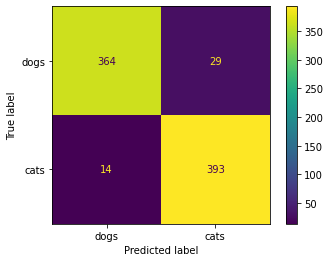

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Crear matriz de confusión
cm = metrics.confusion_matrix(np.argmax(ytest, axis=1), pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dogs', 'cats'])
cm_display.plot()
plt.show()

#### Red Xception

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense

# Importar la red 
xception = keras.applications.Xception(weights=None, input_shape=(150,150,3), include_top=False)
# Congelar la red
xception.trainable = False

# Añadir capa densa
model_X1 = xception.output
model_X1 = Flatten()(model_X1)
model_X1 = Dense(90, activation='relu')(model_X1)
model_X1 = Dense(30, activation='relu')(model_X1)
model_X1 = Dense(2, activation='sigmoid')(model_X1)

Xception1 = Model(inputs=xception.input, outputs=model_X1)

# Configurar el modelo
Xception1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics=['accuracy'])

In [ ]:
Xception1.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 5s 34ms/step - loss: 0.6934 - accuracy: 0.4858 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 2/15
75/75 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/15
75/75 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 4/15
75/75 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 5/15
75/75 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 6/15
75/75 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 7/15
75/75 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 8/15
75

Hacemos Fine Tuning

In [ ]:
# Descongelamos las capas
xception.trainable = True

# Configurar el modelo
Xception1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Xception1.fit(xtrain, ytrain, validation_data=(xval,yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 16s 149ms/step - loss: 0.6816 - accuracy: 0.5913 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/15
75/75 [==============================] - 11s 141ms/step - loss: 0.5914 - accuracy: 0.7017 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/15
75/75 [==============================] - 11s 147ms/step - loss: 0.5108 - accuracy: 0.7867 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 4/15
75/75 [==============================] - 11s 145ms/step - loss: 0.4347 - accuracy: 0.8608 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 5/15
75/75 [==============================] - 11s 145ms/step - loss: 0.3606 - accuracy: 0.9217 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/15
75/75 [==============================] - 11s 146ms/step - loss: 0.2624 - accuracy: 0.9463 - val_loss: 0.6906 - val_accuracy: 0.5750
Epoch 7/15
75/75 [==============================] - 11s 140ms/step - loss: 0.1564 - accuracy: 0.9787 - val_loss: 0.6845 - val_accuracy: 0.5300

Evaluar Xception sin pesos transferidos

In [ ]:
# Predecir con el modelo
pred = Xception1.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_Xception1 = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_Xception1)

25/25 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

         dog       0.65      0.78      0.71       393
         cat       0.74      0.59      0.66       407

    accuracy                           0.69       800
   macro avg       0.70      0.69      0.69       800
weighted avg       0.70      0.69      0.68       800



#### Red InceptionResNetV2

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense

# Importar la red 
resnet = keras.applications.InceptionResNetV2(weights=None, input_shape=(150,150,3), include_top=False)
# Congelar la red
resnet.trainable = False

# Añadir capa densa
model_R1 = resnet.output
model_R1 = Flatten()(model_R1)
model_R1 = Dense(90, activation='relu')(model_R1)
model_R1 = Dense(30, activation='relu')(model_R1)
model_R1 = Dense(2, activation='sigmoid')(model_R1)

Resnet1 = Model(inputs=resnet.input, outputs=model_R1)

# Configurar el modelo
Resnet1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics=['accuracy'])

In [ ]:
Resnet1.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 17s 90ms/step - loss: 0.6959 - accuracy: 0.4975 - val_loss: 0.6924 - val_accuracy: 0.5537
Epoch 2/15
75/75 [==============================] - 3s 44ms/step - loss: 0.6918 - accuracy: 0.5233 - val_loss: 0.6905 - val_accuracy: 0.5013
Epoch 3/15
75/75 [==============================] - 3s 44ms/step - loss: 0.6903 - accuracy: 0.5213 - val_loss: 0.6866 - val_accuracy: 0.5300
Epoch 4/15
75/75 [==============================] - 3s 44ms/step - loss: 0.6879 - accuracy: 0.5429 - val_loss: 0.6874 - val_accuracy: 0.5025
Epoch 5/15
75/75 [==============================] - 3s 45ms/step - loss: 0.6857 - accuracy: 0.5725 - val_loss: 0.6884 - val_accuracy: 0.5038
Epoch 6/15
75/75 [==============================] - 3s 45ms/step - loss: 0.6763 - accuracy: 0.5967 - val_loss: 0.6660 - val_accuracy: 0.6637
Epoch 7/15
75/75 [==============================] - 3s 44ms/step - loss: 0.6654 - accuracy: 0.6158 - val_loss: 0.6690 - val_accuracy: 0.5587
Epoch 8/15
7

Fine Tuning

In [ ]:
# Descongelamos las capas
resnet.trainable = True

# Configurar el modelo
Resnet1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Resnet1.fit(xtrain, ytrain, validation_data=(xval,yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 30s 162ms/step - loss: 40.2010 - accuracy: 0.5250 - val_loss: 38.1920 - val_accuracy: 0.4975
Epoch 2/15
75/75 [==============================] - 9s 118ms/step - loss: 8.9253 - accuracy: 0.6392 - val_loss: 25.7916 - val_accuracy: 0.4975
Epoch 3/15
75/75 [==============================] - 9s 120ms/step - loss: 2.3252 - accuracy: 0.7542 - val_loss: 15.7848 - val_accuracy: 0.4975
Epoch 4/15
75/75 [==============================] - 9s 117ms/step - loss: 1.0113 - accuracy: 0.8167 - val_loss: 8.0106 - val_accuracy: 0.4975
Epoch 5/15
75/75 [==============================] - 9s 117ms/step - loss: 0.5547 - accuracy: 0.8533 - val_loss: 1.9252 - val_accuracy: 0.5200
Epoch 6/15
75/75 [==============================] - 9s 118ms/step - loss: 0.3837 - accuracy: 0.8821 - val_loss: 2.1574 - val_accuracy: 0.5300
Epoch 7/15
75/75 [==============================] - 9s 119ms/step - loss: 0.3019 - accuracy: 0.9079 - val_loss: 1.6193 - val_accuracy: 0.5788
E

Evaluar ResnetV2 sin pesos transferidos

In [ ]:
# Predecir con el modelo
pred = Resnet1.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_Resnet1 = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_Resnet1)

25/25 [==============================] - 4s 35ms/step
              precision    recall  f1-score   support

         dog       0.60      0.70      0.65       393
         cat       0.66      0.55      0.60       407

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.63      0.62      0.62       800



#### Red MobileNetV2

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense

# Importar la red 
mobile = keras.applications.MobileNetV2(weights=None, input_shape=(150,150,3), include_top=False)
# Congelar la red
mobile.trainable = False

# Añadir capa densa
model_M1 = mobile.output
model_M1 = Flatten()(model_M1)
model_M1 = Dense(90, activation='relu')(model_M1)
model_M1 = Dense(30, activation='relu')(model_M1)
model_M1 = Dense(2, activation='sigmoid')(model_M1)

Mobile1 = Model(inputs=mobile.input, outputs=model_M1)

# Configurar el modelo
Mobile1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics=['accuracy'])

In [ ]:
Mobile1.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 4s 25ms/step - loss: 0.6935 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/15
75/75 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/15
75/75 [==============================] - 1s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 4/15
75/75 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 5/15
75/75 [==============================] - 1s 12ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 6/15
75/75 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.4904 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 7/15
75/75 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 8/15
75

Fine Tuning

In [ ]:
# Descongelamos las capas
mobile.trainable = True

# Configurar el modelo
Mobile1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Mobile1.fit(xtrain, ytrain, validation_data=(xval,yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 12s 94ms/step - loss: 0.7017 - accuracy: 0.5496 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 2/15
75/75 [==============================] - 6s 81ms/step - loss: 0.6846 - accuracy: 0.5508 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 3/15
75/75 [==============================] - 6s 82ms/step - loss: 0.6727 - accuracy: 0.5700 - val_loss: 0.6935 - val_accuracy: 0.4975
Epoch 4/15
75/75 [==============================] - 6s 83ms/step - loss: 0.6663 - accuracy: 0.5796 - val_loss: 0.6936 - val_accuracy: 0.4975
Epoch 5/15
75/75 [==============================] - 6s 83ms/step - loss: 0.6631 - accuracy: 0.5904 - val_loss: 0.6942 - val_accuracy: 0.4975
Epoch 6/15
75/75 [==============================] - 6s 84ms/step - loss: 0.6614 - accuracy: 0.6000 - val_loss: 0.6953 - val_accuracy: 0.4975
Epoch 7/15
75/75 [==============================] - 6s 84ms/step - loss: 0.6508 - accuracy: 0.6179 - val_loss: 0.6973 - val_accuracy: 0.4975
Epoch 8/15
7

Evaluar MobileNet sin pesos transferidos

In [ ]:
# Predecir con el modelo
pred = Mobile1.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_Mobile1 = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_Mobile1)

25/25 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

         dog       0.00      0.00      0.00       393
         cat       0.51      1.00      0.67       407

    accuracy                           0.51       800
   macro avg       0.25      0.50      0.34       800
weighted avg       0.26      0.51      0.34       800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Redes con pesos transferidos

#### Red Xception con pesos Imagenet

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense

# Importar la red 
xception2 = keras.applications.Xception(weights='imagenet', input_shape=(150,150,3), include_top=False)
# Congelar la red
xception2.trainable = False

# Añadir capa densa
model_X2 = xception2.output
model_X2 = Flatten()(model_X2)
model_X2 = Dense(90, activation='relu')(model_X2)
model_X2 = Dense(30, activation='relu')(model_X2)
model_X2 = Dense(2, activation='sigmoid')(model_X2)

Xception2 = Model(inputs=xception2.input, outputs=model_X2)

# Configurar el modelo
Xception2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics=['accuracy'])

83683744/83683744 [==============================] - 7s 0us/step


In [ ]:
Xception2.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 5s 31ms/step - loss: 0.2905 - accuracy: 0.9312 - val_loss: 0.2181 - val_accuracy: 0.9538
Epoch 2/15
75/75 [==============================] - 1s 19ms/step - loss: 0.1898 - accuracy: 0.9621 - val_loss: 0.2904 - val_accuracy: 0.9525
Epoch 3/15
75/75 [==============================] - 1s 19ms/step - loss: 0.1141 - accuracy: 0.9787 - val_loss: 0.5046 - val_accuracy: 0.9400
Epoch 4/15
75/75 [==============================] - 1s 20ms/step - loss: 0.0932 - accuracy: 0.9800 - val_loss: 0.1655 - val_accuracy: 0.9675
Epoch 5/15
75/75 [==============================] - 1s 20ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.1676 - val_accuracy: 0.9613
Epoch 6/15
75/75 [==============================] - 1s 19ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.1595 - val_accuracy: 0.9638
Epoch 7/15
75/75 [==============================] - 1s 19ms/step - loss: 5.0912e-04 - accuracy: 1.0000 - val_loss: 0.1607 - val_accuracy: 0.9625
Epoch 8/1

Fine Tuning

In [ ]:
# Descongelamos las capas
xception2.trainable = True

# Configurar el modelo
Xception2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Xception2.fit(xtrain, ytrain, validation_data=(xval,yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 16s 154ms/step - loss: 0.2821 - accuracy: 0.8717 - val_loss: 0.1627 - val_accuracy: 0.9563
Epoch 2/15
75/75 [==============================] - 10s 140ms/step - loss: 0.1704 - accuracy: 0.9267 - val_loss: 0.1706 - val_accuracy: 0.9362
Epoch 3/15
75/75 [==============================] - 11s 140ms/step - loss: 0.1067 - accuracy: 0.9633 - val_loss: 0.1750 - val_accuracy: 0.9262
Epoch 4/15
75/75 [==============================] - 10s 136ms/step - loss: 0.0792 - accuracy: 0.9762 - val_loss: 0.1753 - val_accuracy: 0.9262
Epoch 5/15
75/75 [==============================] - 10s 137ms/step - loss: 0.0488 - accuracy: 0.9883 - val_loss: 0.1742 - val_accuracy: 0.9250
Epoch 6/15
75/75 [==============================] - 10s 134ms/step - loss: 0.0404 - accuracy: 0.9887 - val_loss: 0.1736 - val_accuracy: 0.9237
Epoch 7/15
75/75 [==============================] - 10s 134ms/step - loss: 0.0283 - accuracy: 0.9937 - val_loss: 0.1707 - val_accuracy: 0.9275

Evaluar Xception con pesos transferidos

In [ ]:
# Predecir con el modelo
pred = Xception2.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_Xception2 = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_Xception2)

25/25 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

         dog       0.93      0.91      0.92       393
         cat       0.91      0.93      0.92       407

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



#### Red InceptionResNetV2 con pesos Imagenet

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense

# Importar la red 
resnet2 = keras.applications.InceptionResNetV2(weights='imagenet', input_shape=(150,150,3), include_top=False)
# Congelar la red
resnet2.trainable = False

# Añadir capa densa
model_R2 = resnet2.output
model_R2 = Flatten()(model_R2)
model_R2 = Dense(90, activation='relu')(model_R2)
model_R2 = Dense(30, activation='relu')(model_R2)
model_R2 = Dense(2, activation='sigmoid')(model_R2)

Resnet2 = Model(inputs=resnet2.input, outputs=model_R2)

# Configurar el modelo
Resnet2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics=['accuracy'])

219055592/219055592 [==============================] - 15s 0us/step


In [ ]:
Resnet2.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 17s 89ms/step - loss: 0.4689 - accuracy: 0.9413 - val_loss: 0.6058 - val_accuracy: 0.9362
Epoch 2/15
75/75 [==============================] - 3s 44ms/step - loss: 0.1503 - accuracy: 0.9733 - val_loss: 0.1355 - val_accuracy: 0.9712
Epoch 3/15
75/75 [==============================] - 3s 44ms/step - loss: 0.0664 - accuracy: 0.9829 - val_loss: 0.2224 - val_accuracy: 0.9750
Epoch 4/15
75/75 [==============================] - 3s 44ms/step - loss: 0.0661 - accuracy: 0.9850 - val_loss: 0.1745 - val_accuracy: 0.9750
Epoch 5/15
75/75 [==============================] - 3s 45ms/step - loss: 0.0173 - accuracy: 0.9933 - val_loss: 0.2270 - val_accuracy: 0.9575
Epoch 6/15
75/75 [==============================] - 3s 45ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.1617 - val_accuracy: 0.9638
Epoch 7/15
75/75 [==============================] - 3s 46ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.2026 - val_accuracy: 0.9675
Epoch 8/15
7

Fine Tuning

In [ ]:
# Descongelamos las capas
resnet2.trainable = True

# Configurar el modelo
Resnet2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Resnet2.fit(xtrain, ytrain, validation_data=(xval,yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 29s 160ms/step - loss: 0.3651 - accuracy: 0.8167 - val_loss: 0.1999 - val_accuracy: 0.9350
Epoch 2/15
75/75 [==============================] - 9s 118ms/step - loss: 0.2077 - accuracy: 0.9158 - val_loss: 0.1648 - val_accuracy: 0.9362
Epoch 3/15
75/75 [==============================] - 9s 117ms/step - loss: 0.1324 - accuracy: 0.9579 - val_loss: 0.1673 - val_accuracy: 0.9350
Epoch 4/15
75/75 [==============================] - 9s 118ms/step - loss: 0.0890 - accuracy: 0.9737 - val_loss: 0.2025 - val_accuracy: 0.9275
Epoch 5/15
75/75 [==============================] - 9s 117ms/step - loss: 0.0476 - accuracy: 0.9896 - val_loss: 0.2300 - val_accuracy: 0.9200
Epoch 6/15
75/75 [==============================] - 9s 117ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.2502 - val_accuracy: 0.9187
Epoch 7/15
75/75 [==============================] - 9s 118ms/step - loss: 0.0229 - accuracy: 0.9971 - val_loss: 0.2707 - val_accuracy: 0.9100
Epoch

Evaluar ResnetV2 con pesos transferidos

In [ ]:
# Predecir con el modelo
pred = Resnet2.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_Resnet2 = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_Resnet2)

25/25 [==============================] - 4s 34ms/step
              precision    recall  f1-score   support

         dog       0.93      0.89      0.91       393
         cat       0.90      0.93      0.92       407

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



#### Red MobileNetV2 con pesos Imagenet

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense

# Importar la red 
mobile2 = keras.applications.MobileNetV2(weights='imagenet', input_shape=(150,150,3), include_top=False)
# Congelar la red
mobile2.trainable = False

# Añadir capa densa
model_M2 = mobile2.output
model_M2 = Flatten()(model_M2)
model_M2 = Dense(90, activation='relu')(model_M2)
model_M2 = Dense(30, activation='relu')(model_M2)
model_M2 = Dense(2, activation='sigmoid')(model_M2)

Mobile2 = Model(inputs=mobile2.input, outputs=model_M2)

# Configurar el modelo
Mobile2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
Mobile2.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 4s 25ms/step - loss: 0.6370 - accuracy: 0.9229 - val_loss: 0.3008 - val_accuracy: 0.9525
Epoch 2/15
75/75 [==============================] - 1s 13ms/step - loss: 0.1009 - accuracy: 0.9783 - val_loss: 0.2943 - val_accuracy: 0.9500
Epoch 3/15
75/75 [==============================] - 1s 13ms/step - loss: 0.0239 - accuracy: 0.9908 - val_loss: 0.3503 - val_accuracy: 0.9563
Epoch 4/15
75/75 [==============================] - 1s 12ms/step - loss: 0.0195 - accuracy: 0.9929 - val_loss: 0.3182 - val_accuracy: 0.9550
Epoch 5/15
75/75 [==============================] - 1s 12ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.2867 - val_accuracy: 0.9575
Epoch 6/15
75/75 [==============================] - 1s 13ms/step - loss: 4.3874e-04 - accuracy: 1.0000 - val_loss: 0.3021 - val_accuracy: 0.9625
Epoch 7/15
75/75 [==============================] - 1s 12ms/step - loss: 1.3177e-04 - accuracy: 1.0000 - val_loss: 0.2997 - val_accuracy: 0.9563
Epoch

Fine Tuning

In [ ]:
# Descongelamos las capas
mobile2.trainable = True

# Configurar el modelo
Mobile2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Mobile2.fit(xtrain, ytrain, validation_data=(xval,yval), epochs = 15 , batch_size = 32, verbose = 1)

Epoch 1/15
75/75 [==============================] - 11s 95ms/step - loss: 0.4988 - accuracy: 0.8763 - val_loss: 0.3410 - val_accuracy: 0.9563
Epoch 2/15
75/75 [==============================] - 6s 84ms/step - loss: 0.1600 - accuracy: 0.9429 - val_loss: 0.3083 - val_accuracy: 0.9575
Epoch 3/15
75/75 [==============================] - 6s 81ms/step - loss: 0.1038 - accuracy: 0.9613 - val_loss: 0.2641 - val_accuracy: 0.9588
Epoch 4/15
75/75 [==============================] - 6s 82ms/step - loss: 0.0793 - accuracy: 0.9708 - val_loss: 0.2481 - val_accuracy: 0.9538
Epoch 5/15
75/75 [==============================] - 6s 82ms/step - loss: 0.0911 - accuracy: 0.9621 - val_loss: 0.2256 - val_accuracy: 0.9563
Epoch 6/15
75/75 [==============================] - 6s 84ms/step - loss: 0.0414 - accuracy: 0.9825 - val_loss: 0.2146 - val_accuracy: 0.9550
Epoch 7/15
75/75 [==============================] - 6s 84ms/step - loss: 0.0352 - accuracy: 0.9862 - val_loss: 0.2128 - val_accuracy: 0.9538
Epoch 8/15
7

Evaluar MobileNet con pesos transferidos

In [ ]:
# Predecir con el modelo
pred = Mobile2.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_Mobile2 = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_Mobile1)

25/25 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

         dog       0.00      0.00      0.00       393
         cat       0.51      1.00      0.67       407

    accuracy                           0.51       800
   macro avg       0.25      0.50      0.34       800
weighted avg       0.26      0.51      0.34       800

